# Cleaning TestingData

## Summary and Table of Contents
This notebook is going to be used to load and  clean the data


### Importing Libraries and Training Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

In [2]:
!ls datasets/

data_fillna.csv    sub_01.csv         test.csv           train.csv
sample_sub_reg.csv sub_02.csv         test_fillna.csv


In [3]:
df = pd.read_csv('datasets/test.csv')

### Looking at the Data
We are going  to check for missing data values in each of our columns. Starting at the most problematic columns.

#### Missing Data and MissingNo
We will use Missingno to visualize any missing data. Our goal is to have the below graphic totally black.

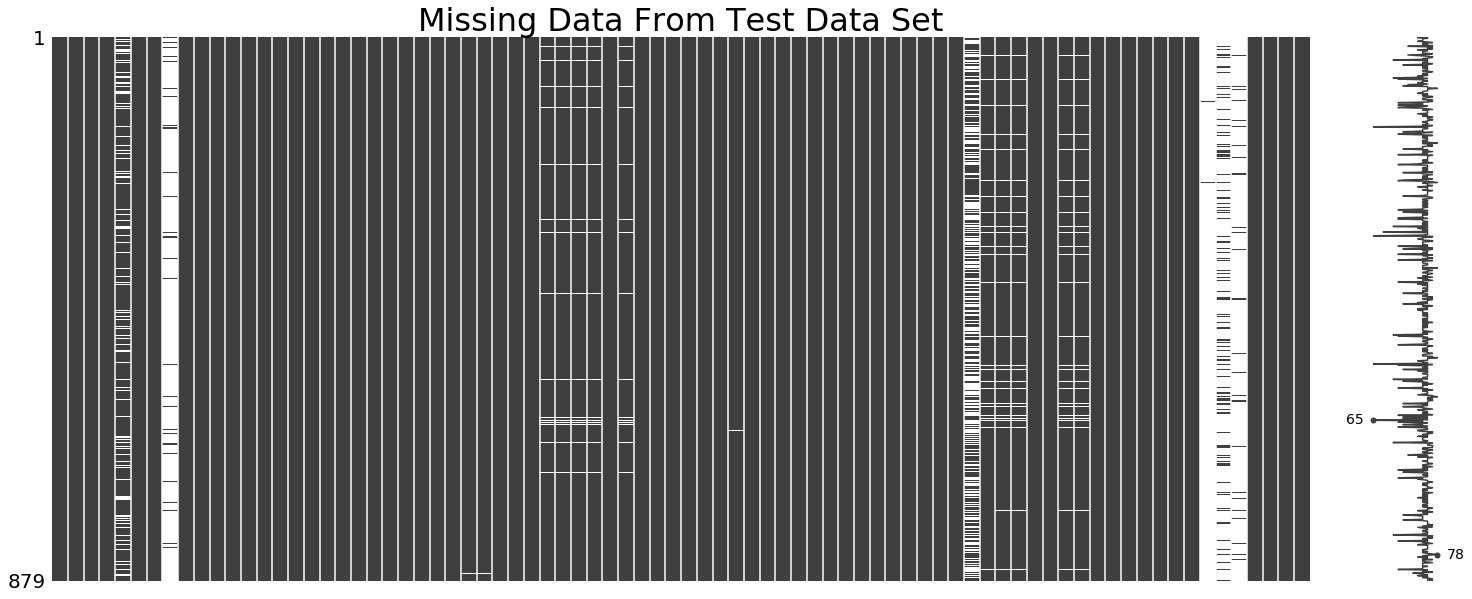

In [4]:
# Check for missing values in each row
msno.matrix(df);
plt.title("Missing Data From Test Data Set",size=32);

##### Targeting Problem Columns
Let's sort the data by the highest number of missing values to systemize our data cleaning.

There are 6 columns with more than 10% missing values.
There are 10 columns with between 1% and 10% missing values, inclusive.
There are 64 columns with less than 1% missing values.
Pool QC
Ex    3
TA    1
Name: Pool QC, dtype: int64
Misc Feature
Shed    39
Gar2     1
Othr     1
Name: Misc Feature, dtype: int64
Alley
Grvl    35
Pave    23
Name: Alley, dtype: int64
Fence
MnPrv    103
GdPrv     35
GdWo      32
MnWw       2
Name: Fence, dtype: int64
Fireplace Qu
Gd    221
TA    193
Fa     16
Po     15
Ex     12
Name: Fireplace Qu, dtype: int64
Lot Frontage
60.0     97
80.0     43
70.0     37
75.0     37
50.0     27
         ..
122.0     1
150.0     1
31.0      1
112.0     1
133.0     1
Name: Lot Frontage, Length: 104, dtype: int64


(Index(['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu',
        'Lot Frontage'],
       dtype='object'),
 Index(['Garage Cond', 'Garage Qual', 'Garage Yr Blt', 'Garage Finish',
        'Garage Type', 'Bsmt Exposure', 'BsmtFin Type 1', 'Bsmt Qual',
        'BsmtFin Type 2', 'Bsmt Cond'],
       dtype='object'),
 Index(['Mas Vnr Area', 'Mas Vnr Type', 'Electrical', 'Overall Cond',
        'Exter Qual', 'Exter Cond', 'Foundation', 'Exterior 2nd',
        'Exterior 1st', 'Roof Matl', 'Roof Style', 'Year Remod/Add',
        'Year Built', 'Sale Type', 'Overall Qual', 'House Style', 'Bldg Type',
        'Condition 2', 'Condition 1', 'Land Slope', 'Lot Config', 'Utilities',
        'Land Contour', 'Lot Shape', 'Street', 'Lot Area', 'MS Zoning',
        'MS SubClass', 'PID', 'Neighborhood', 'Total Bsmt SF', 'BsmtFin SF 1',
        'Kitchen Qual', 'Mo Sold', 'Misc Val', 'Pool Area', 'Screen Porch',
        '3Ssn Porch', 'Enclosed Porch', 'Open Porch SF', 'Wood Deck SF',
        'Pav

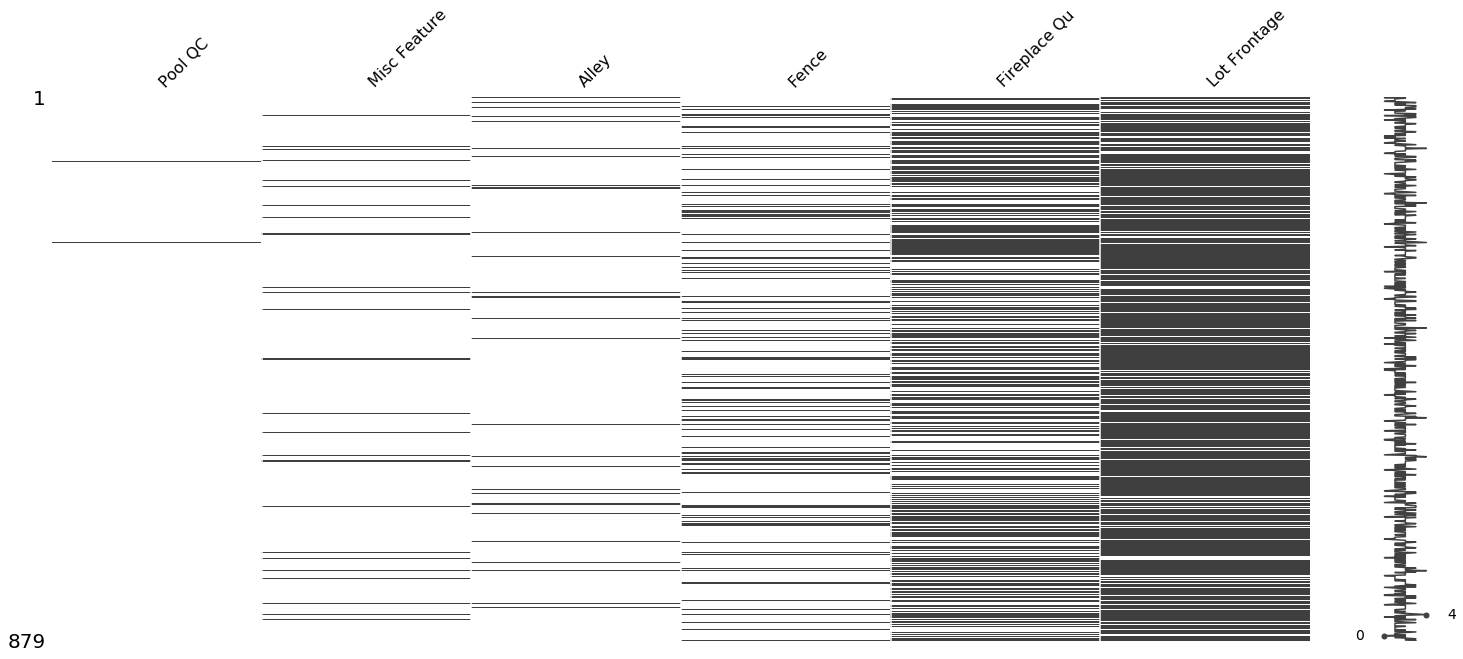

In [5]:
# Check for missing values in each row and sort by the most problematic.
def parse_bad_cols():
    bad_cols = df.isnull().mean().sort_values(ascending=False)

    # Seperate the columns into most,  mildly and hardly  problematic.
    bad_10 = bad_cols[bad_cols > 0.10].index
    print(f"There are {len(bad_10)} columns with more than 10% missing values.")

    bad_01 = bad_cols[bad_cols.between(0.01, 0.10)].index
    print(f"There are {len(bad_01)} columns with between 1% and 10% missing values, inclusive.")

    bad_00 = bad_cols[bad_cols < 0.01].index
    print(f"There are {len(bad_00)} columns with less than 1% missing values.")
    
    if len(bad_10) == 0:
        return bad_10, bad_01, bad_00
    else:
        for col in bad_10:
            print(col)
            print(df[col].value_counts())
        msno.matrix(df[bad_10]);
    return bad_10, bad_01, bad_00
parse_bad_cols()

There are 6 columns with more than 10% missing values.
There are 10 columns with between 1% and 10% missing values, inclusive.
There are 64 columns with less than 1% missing values.
Pool QC
Ex    3
TA    1
Name: Pool QC, dtype: int64
Misc Feature
Shed    39
Gar2     1
Othr     1
Name: Misc Feature, dtype: int64
Alley
Grvl    35
Pave    23
Name: Alley, dtype: int64
Fence
MnPrv    103
GdPrv     35
GdWo      32
MnWw       2
Name: Fence, dtype: int64
Fireplace Qu
Gd    221
TA    193
Fa     16
Po     15
Ex     12
Name: Fireplace Qu, dtype: int64
Lot Frontage
60.0     97
80.0     43
70.0     37
75.0     37
50.0     27
         ..
122.0     1
150.0     1
31.0      1
112.0     1
133.0     1
Name: Lot Frontage, Length: 104, dtype: int64
Pool QC
Ex    3
TA    1
Name: Pool QC, dtype: int64
Misc Feature
Shed    39
Gar2     1
Othr     1
Name: Misc Feature, dtype: int64
Alley
Grvl    35
Pave    23
Name: Alley, dtype: int64
Fence
MnPrv    103
GdPrv     35
GdWo      32
MnWw       2
Name: Fence, dtype:

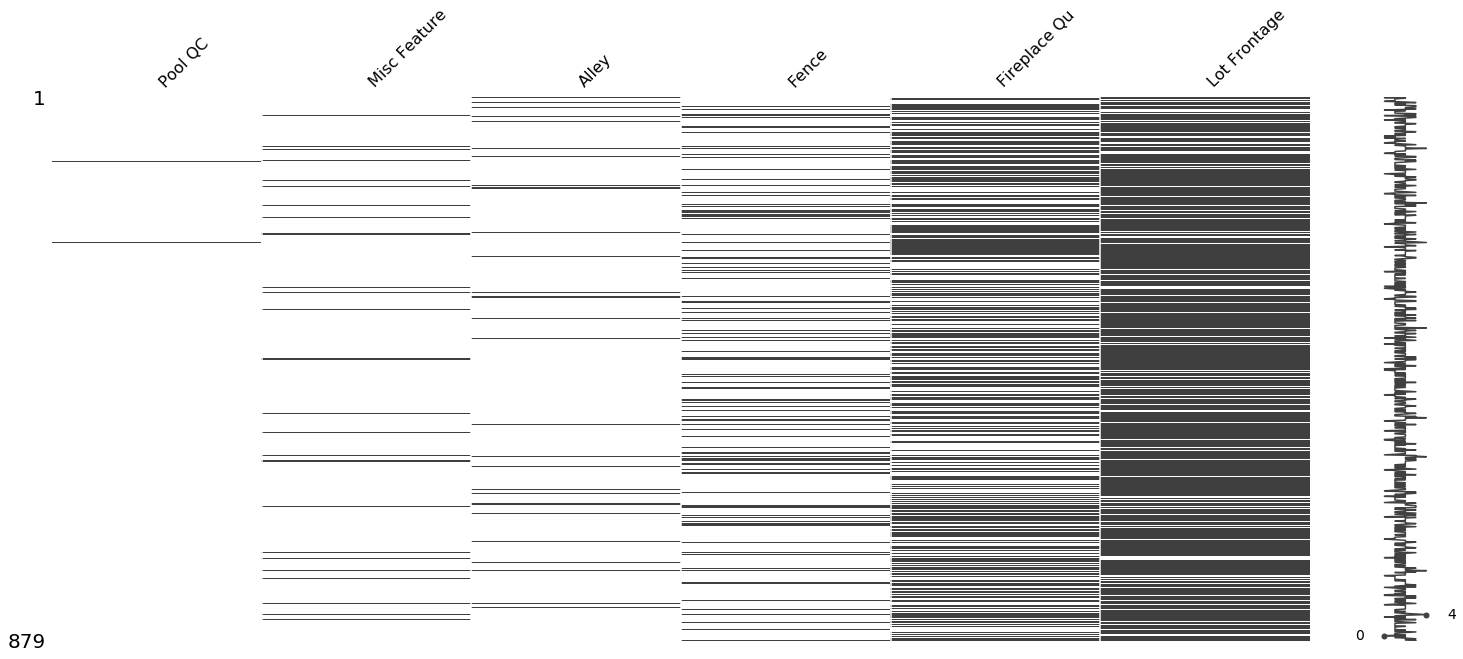

In [6]:
for col in parse_bad_cols()[0]:
    print(col)
    print(df[col].value_counts())

##### `bad_10` columns: Quality Scales
It looks like columns `'Pool QC'` and `'Fireplace Qu'` values are put on a  similar **qualitative scale**. The `'Pool QC'` has the qualitative values below:

|Code|Quality|
|---|---|
|Ex|Excellent|
|Gd|Good|
|TA|Average/Typical|
|Fa|Fair|
|NA|No Pool|

Entries for 'NA' are being interpreted as `np.nan` values, which is resulting in our high percentage of nulls. This scale can be converted into a  numeric scale using the information in the [variable descriptions](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) page. 
We can fill the null values and convert the `'Pool QC'` and `'Fireplace Qu'` columns to numeric scales.

We will also look for **any other columns** in the data frame that can be corrected  in this way. We  will save these columns  in a list called `qual_cols` and convert them using the `.map()` method and the the `quality_dict` dictionary below.

In [7]:
qual_dict = {
        'Ex':5,
        'Gd':4,
        'TA':3,
        'Fa':2,
        'Po':1,
        'None':0
    }
qual_str = "(^" + "$|^".join(qual_dict.keys()) + "$)"
qual_str

'(^Ex$|^Gd$|^TA$|^Fa$|^Po$|^None$)'

In [8]:
qual_cols = []
for col in df.columns:
    if df[col].dtype == 'object':
        if df[col].str.contains(r"(^Ex$|^Gd$|^TA$|^Fa$|^Po$)",regex=True).sum():
            qual_cols.append(col)
qual_cols

/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/anaconda3/lib/python3.7/site-

['Exter Qual',
 'Exter Cond',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'Heating QC',
 'Kitchen Qual',
 'Fireplace Qu',
 'Garage Qual',
 'Garage Cond',
 'Pool QC']

##### Filling `nan` values with 'None' in  `'Quality'` Columns

This is similar to many other qualitative columns in our data. We are going to create a `quality_dict`, to hold our quality-quantitative pairs and the function `qual_to_quant` to apply the conversions.

In [9]:
# Fill the  column's null values with 'None' so that we can apply the dictionary.
for col in df[qual_cols]:
    df[col].fillna('None',inplace=True)
    print(col,df[col].unique())

Exter Qual ['TA' 'Gd' 'Fa' 'Ex']
Exter Cond ['Fa' 'TA' 'Gd' 'Ex' 'Po']
Bsmt Qual ['Fa' 'Gd' 'TA' 'Ex' 'None' 'Po']
Bsmt Cond ['TA' 'Gd' 'None' 'Fa']
Bsmt Exposure ['No' 'Av' 'None' 'Mn' 'Gd']
Heating QC ['Gd' 'TA' 'Ex' 'Fa']
Kitchen Qual ['Fa' 'TA' 'Gd' 'Ex' 'Po']
Fireplace Qu ['None' 'Gd' 'Fa' 'TA' 'Po' 'Ex']
Garage Qual ['Po' 'TA' 'Fa' 'None' 'Gd']
Garage Cond ['Po' 'TA' 'None' 'Fa' 'Gd' 'Ex']
Pool QC ['None' 'Ex' 'TA']


Since `'Bsmt Exposure'` does not have the same qualitative scale, we will deal with it later using a separate dictionary.

In [10]:
qual_cols.remove('Bsmt Exposure')

##### Converting the qualitative values to quantitative using `.map(qual_dict)`
Here we convert the  qualitative values of our columns to a  numeric scale usign the `.map()` and `qual_dict` dictionary.

In [11]:
for col in qual_cols:
    df[col] = df[col].map(qual_dict)
df[qual_cols]

,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Heating QC,Kitchen Qual,Fireplace Qu,Garage Qual,Garage Cond,Pool QC
0,3,2,2,3,4,2,0,1,1,0
1,3,3,4,3,3,3,0,3,3,0
2,4,3,4,4,5,4,4,3,3,0
3,4,3,3,3,3,3,0,2,3,0
4,3,3,4,3,4,3,4,3,3,0
...,...,...,...,...,...,...,...,...,...,...
874,3,3,3,3,3,3,3,3,3,0
875,4,4,3,3,5,4,4,3,3,0
876,3,3,3,3,5,3,3,3,3,0
877,3,3,3,3,3,3,0,3,3,0


#### DONE ! Qualitative Columns:  Nulls Filled and Numerically Converted
We have cleaned 10 columns of data (2 of which were fromour `bad_10` columns. Now we will re-parse the columns with missing data and do it all again.

There are 4 columns with more than 10% missing values.
There are 5 columns with between 1% and 10% missing values, inclusive.
There are 71 columns with less than 1% missing values.
Misc Feature
Shed    39
Gar2     1
Othr     1
Name: Misc Feature, dtype: int64
Alley
Grvl    35
Pave    23
Name: Alley, dtype: int64
Fence
MnPrv    103
GdPrv     35
GdWo      32
MnWw       2
Name: Fence, dtype: int64
Lot Frontage
60.0     97
80.0     43
70.0     37
75.0     37
50.0     27
         ..
122.0     1
150.0     1
31.0      1
112.0     1
133.0     1
Name: Lot Frontage, Length: 104, dtype: int64


(Index(['Misc Feature', 'Alley', 'Fence', 'Lot Frontage'], dtype='object'),
 Index(['Garage Yr Blt', 'Garage Finish', 'Garage Type', 'BsmtFin Type 1',
        'BsmtFin Type 2'],
       dtype='object'),
 Index(['Electrical', 'Mas Vnr Area', 'Mas Vnr Type', 'Sale Type',
        'Exterior 1st', 'Roof Style', 'Roof Matl', 'Exter Cond', 'Exterior 2nd',
        'Exter Qual', 'Year Built', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
        'Bsmt Exposure', 'Year Remod/Add', 'Condition 2', 'Overall Cond',
        'Land Contour', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street',
        'Lot Shape', 'Utilities', 'Overall Qual', 'Lot Config', 'Land Slope',
        'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style',
        'BsmtFin SF 1', 'Total Bsmt SF', 'BsmtFin SF 2', 'Bsmt Unf SF',
        'Fireplace Qu', 'Garage Cars', 'Garage Area', 'Garage Qual',
        'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
        'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool 

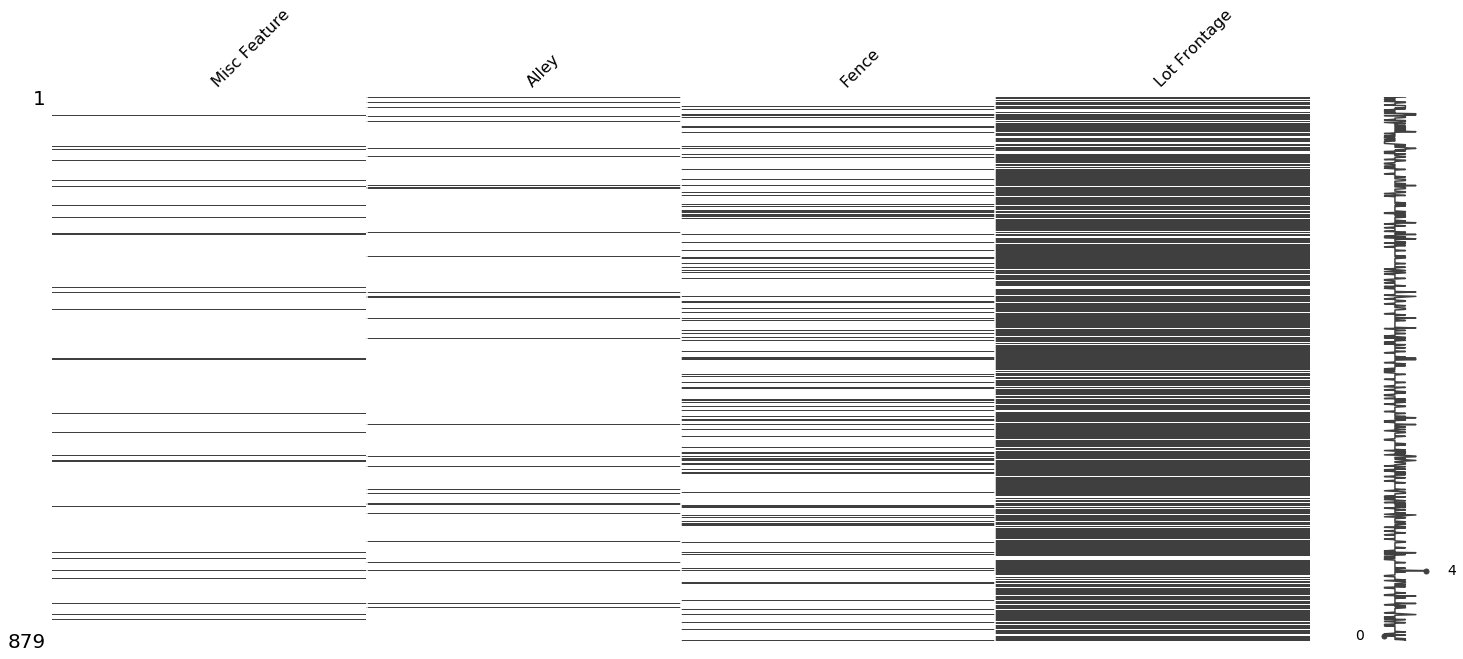

In [12]:
parse_bad_cols()

There are 4 columns with more than 10% missing values.
There are 5 columns with between 1% and 10% missing values, inclusive.
There are 71 columns with less than 1% missing values.
Misc Feature
Shed    39
Gar2     1
Othr     1
Name: Misc Feature, dtype: int64
Alley
Grvl    35
Pave    23
Name: Alley, dtype: int64
Fence
MnPrv    103
GdPrv     35
GdWo      32
MnWw       2
Name: Fence, dtype: int64
Lot Frontage
60.0     97
80.0     43
70.0     37
75.0     37
50.0     27
         ..
122.0     1
150.0     1
31.0      1
112.0     1
133.0     1
Name: Lot Frontage, Length: 104, dtype: int64
Misc Feature 0.9533560864618885
Alley 0.9340159271899886
Fence 0.8043230944254836
Lot Frontage 0.1820250284414107


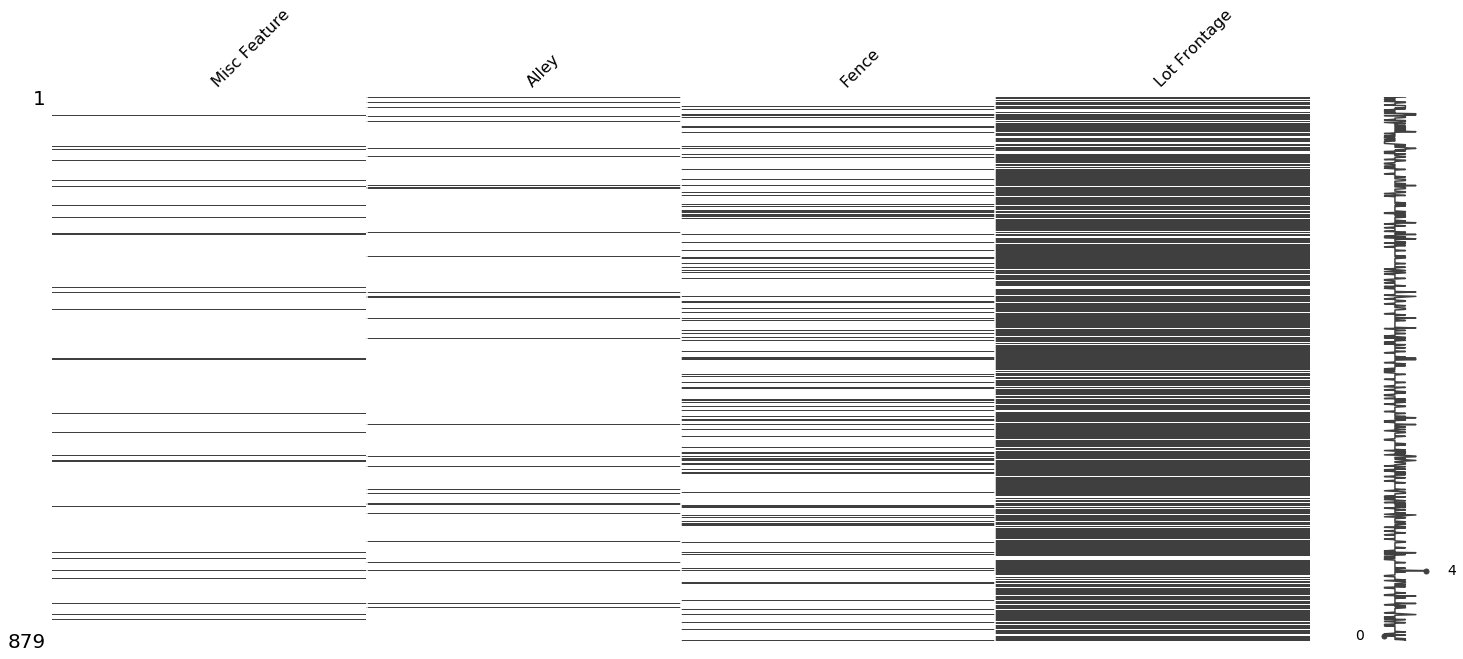

In [13]:
for col in parse_bad_cols()[0]:
    print(col,df[col].isnull().mean())

#### More `NA` and `np.nan` to `'None'` columns 
According to the [variable descriptions](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) page
The `'Misc Feature'` column is a list of features not covered by other categories in the data frame. `NA` is being interpreted as `np.nan`, so we will convert it into the string 'None'.

`NA` is being treated similarly in the `'Alley'` and `'Fence'` columns as well, so we will fix them all now.

There are 1 columns with more than 10% missing values.
There are 5 columns with between 1% and 10% missing values, inclusive.
There are 74 columns with less than 1% missing values.
Lot Frontage
60.0     97
80.0     43
70.0     37
75.0     37
50.0     27
         ..
122.0     1
150.0     1
31.0      1
112.0     1
133.0     1
Name: Lot Frontage, Length: 104, dtype: int64


(Index(['Lot Frontage'], dtype='object'),
 Index(['Garage Yr Blt', 'Garage Finish', 'Garage Type', 'BsmtFin Type 2',
        'BsmtFin Type 1'],
       dtype='object'),
 Index(['Electrical', 'Mas Vnr Area', 'Mas Vnr Type', 'Exterior 2nd',
        'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
        'Exter Qual', 'Overall Cond', 'Exter Cond', 'Foundation', 'Bsmt Qual',
        'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin SF 1', 'Year Built', 'Sale Type',
        'Overall Qual', 'BsmtFin SF 2', 'PID', 'MS SubClass', 'MS Zoning',
        'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
        'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
        'Condition 2', 'Bldg Type', 'House Style', 'Total Bsmt SF',
        'Bsmt Unf SF', 'Fireplace Qu', 'Garage Area', 'Garage Qual',
        'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
        'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Pool QC',
        'Fence', 'Misc

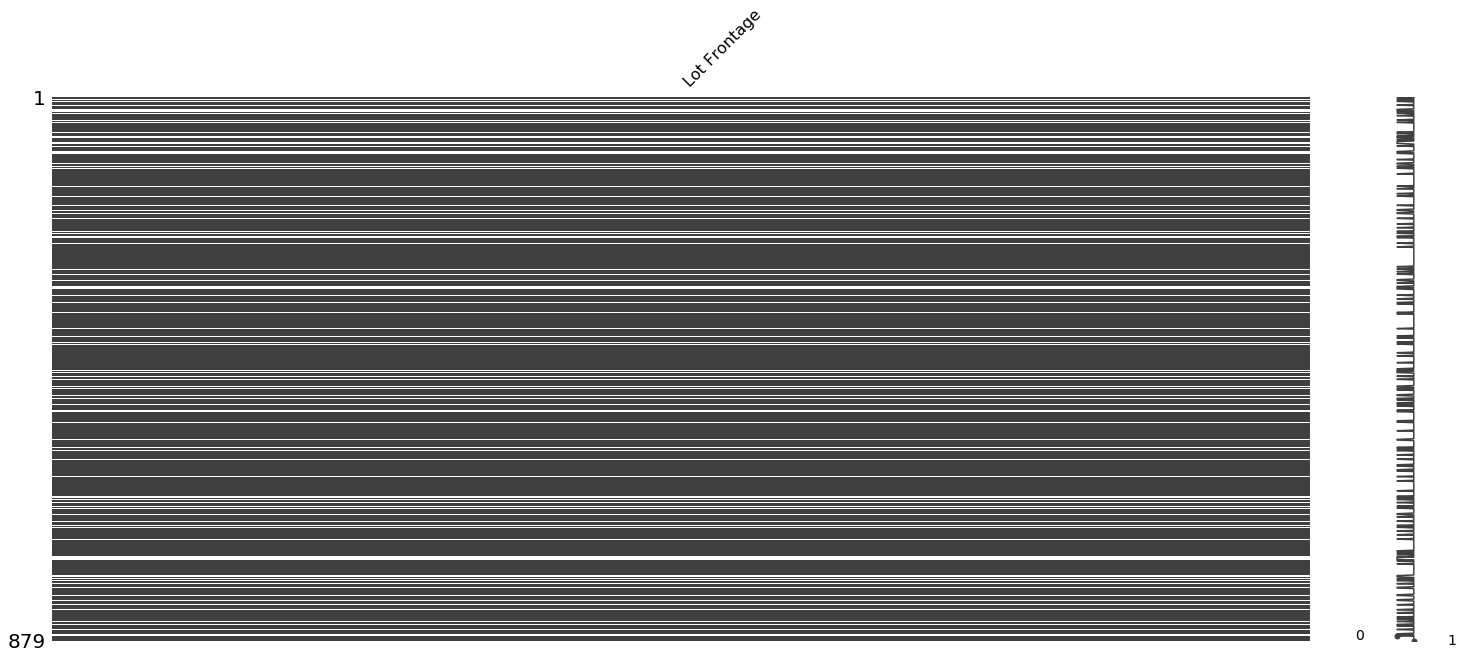

In [14]:
df['Misc Feature'].fillna('None',inplace=True)
df['Alley'].fillna('None',inplace=True)
df['Fence'].fillna('None',inplace=True)
parse_bad_cols()

### We are left with 1 `bad_10` column: `'Lot Frontage'`


#### Filling in `'Lot Frontage'` with a Linear  Regression
We are going to use the relationship between `'Lot Frontage'` and `'Lot Area'` to fill in the  missing values from this column.

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
data_train = df[~df['Lot Frontage'].isnull()]

In [17]:
X = data_train[['Lot Area']]
y = data_train['Lot Frontage']

In [18]:
model = LinearRegression()

In [19]:
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
y_hat = model.predict(df[['Lot Area']])

In [21]:
df['Lot Frontage'] = y_hat

In [22]:
parse_bad_cols();

There are 0 columns with more than 10% missing values.
There are 5 columns with between 1% and 10% missing values, inclusive.
There are 75 columns with less than 1% missing values.


## Insert `'None'` into remaing columns

In [23]:
garage_cols = [col for col in df.columns if 'Gar' in col]

In [24]:
for col in garage_cols:
    df[col].fillna('None',inplace=True)

In [25]:
df[garage_cols].isnull().mean()

Garage Type      0.0
Garage Yr Blt    0.0
Garage Finish    0.0
Garage Cars      0.0
Garage Area      0.0
Garage Qual      0.0
Garage Cond      0.0
dtype: float64

In [26]:
# Impute 'Garge Yr Blt' with 'Year  Built' for rows with missing values.
mask_garage_none = df['Garage Yr Blt'] == 'None'
df.loc[mask_garage_none,'Garage Yr Blt'] = df.loc[mask_garage_none, 'Year Built']

In [27]:
parse_bad_cols()[1]

There are 0 columns with more than 10% missing values.
There are 2 columns with between 1% and 10% missing values, inclusive.
There are 78 columns with less than 1% missing values.


Index(['BsmtFin Type 2', 'BsmtFin Type 1'], dtype='object')

In [28]:
for col in ['BsmtFin Type 2', 'BsmtFin Type 1', 'Mas Vnr Type']:
    df[col].fillna('None',inplace=True)
df['Mas Vnr Area'].fillna(0.0, inplace=True)

In [29]:
bsmt_cols = [col for col in df.columns if 'Bsmt' in col]
df.loc[df['Bsmt Exposure'] != 'None',bsmt_cols].isnull().mean().sort_values()

Bsmt Qual         0.0
Bsmt Cond         0.0
Bsmt Exposure     0.0
BsmtFin Type 1    0.0
BsmtFin SF 1      0.0
BsmtFin Type 2    0.0
BsmtFin SF 2      0.0
Bsmt Unf SF       0.0
Total Bsmt SF     0.0
Bsmt Full Bath    0.0
Bsmt Half Bath    0.0
dtype: float64

The only columns with missing data are those without basements. I am going to impute 0.0 for the Square Footage of these basements.

In [30]:
for col in bsmt_cols:
    df[col].fillna(0.0,inplace=True)

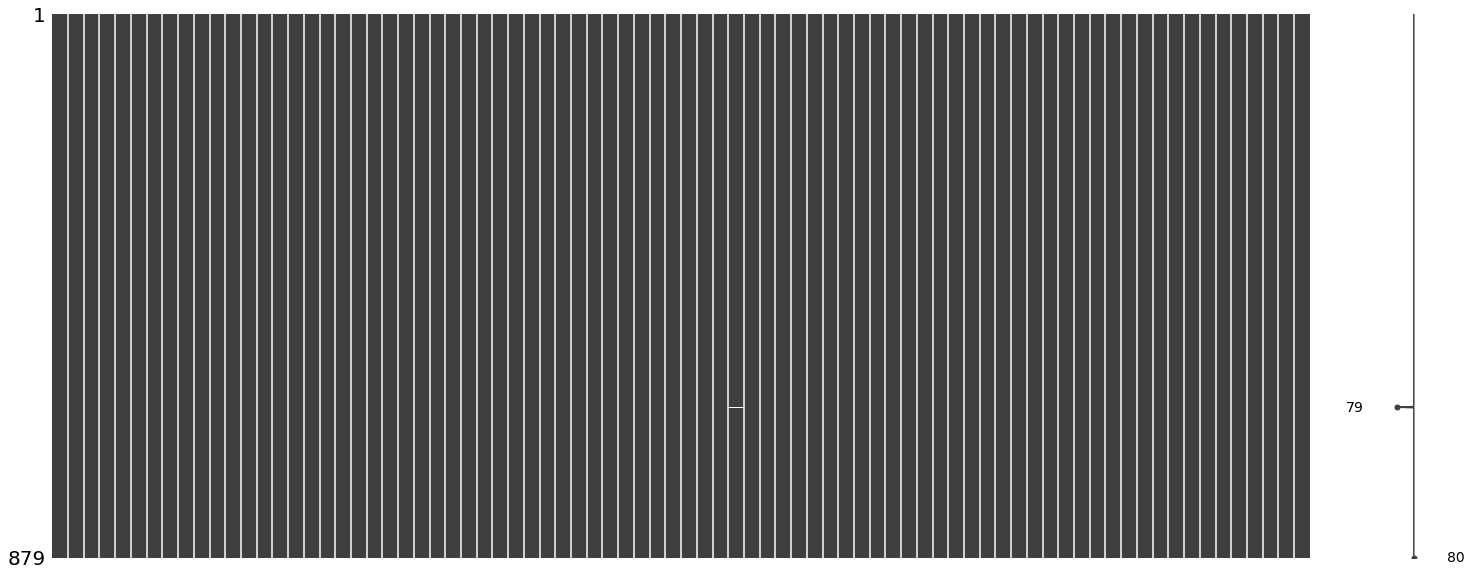

In [31]:
msno.matrix(df)

In [32]:
df.isnull().mean().sort_values()

Id                0.000000
Fireplaces        0.000000
Functional        0.000000
TotRms AbvGrd     0.000000
Kitchen Qual      0.000000
                    ...   
Roof Style        0.000000
Year Remod/Add    0.000000
Exter Qual        0.000000
Sale Type         0.000000
Electrical        0.001138
Length: 80, dtype: float64

In [33]:
df[df['Electrical'].isnull()][['Electrical']]
df.loc[635,['Electrical']] = 'None'

In [34]:
df.to_csv('datasets/test_fillna.csv',index=False)

## Recap
This note book was used to load and clean the data and we will next will be feature extraction and what not.

As we can see above, the columns with greater than 10% missing data  has been corrected.